# Conv4 3D (Masters) vs Conv4 3D Residual

Here we compare performance of the CNN built and trained during Masters with the new residual CNN

* Old CNN:
    * 4 Conv layers
    * 2 dropout layers (rate=0.5)
* New CNN:
    * 4-20 Conv layers
        * 2 residual parts with a Convolution block + 2 Identity blocks
    * 2 dropout layers (rate=0.7) + 2 dropout (rate=0.4) after residual Convs
    
    
* Old data:
    * ~10k samples each class
    * Signal = C100keV
    * Bckg = LNGS (mostly fog)
* New data:
    * ~100k samples each class
    * Signal = C100keV; C60keV; C30keV (~100k each)
    * Bckg = alpha+gamma
    * upgraded scanning process

## Legend:
* New-New = New CNN on New data
* New-Old = New CNN on Old data
* Old-New = Old CNN on New data
* Old-Old = Old CNN on Old data

In [1]:
from keras.models import  load_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, re, gc
import h5py
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

Using TensorFlow backend.


In [2]:
import tensorflow as tf
import keras.backend as K
from cnn_utils import *

# TensorFlow wizardry
config = tf.ConfigProto() 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True 
# Only allow a total of half the GPU memory to be allocated
#config.gpu_options.per_process_gpu_memory_fraction = 0.5 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

tf.logging.set_verbosity(tf.logging.ERROR)

### For comparison we take C100keV as a signal class in both old and new data

In [3]:
X_test, y_test = {}, {}
X_test['new'] , y_test['new'], _ = load_data(sig_n='C100keV', bckg_n='gamma', training=False, images=True)

with h5py.File('/home/scanner-ml/Artem/Python/NEWS/Archive/cnn/dataset.h5','r') as dataf:
    X_test['old'] = dataf['X_test'][...]
    X_test['old'].resize((*X_test['old'].shape, 1))
    y_test['old'] = dataf['Y_test'][...]
    print('\nX_test_old shape:\t',X_test['old'].shape,'\ny_test_old shape:\t',y_test['old'].shape)

X_test shape:	(41754, 32, 32, 8, 1)
y_test shape:	(41754,)

X_test_old shape:	 (4561, 31, 31, 8, 1) 
y_test_old shape:	 (4561, 1)


In [4]:
news_path = '/home/scanner-ml/Artem/Python/NEWS/'
model = {}
model['new_new'] = load_model(news_path+'CNN/networks/conv4_3d_res_v1_e150.h5') 
model['new_old'] = new_input_shape(model['new_new'], X_test['old'].shape[1:])
model['old_old'] = load_model(news_path+'Archive/cnn/ddd_vgg_90perc.h5')
model['old_new'] = new_input_shape(model['old_old'], X_test['new'].shape[1:])

In [5]:
preds, pos, neg, prec_curve, rec_curve, thr_curve = {}, {}, {}, {}, {}, {}

## New CNN

41754/41754 [==============================] - 59s    
new_new roc_auc:	 0.998
4561/4561 [==============================] - 8s     
new_old roc_auc:	 0.64725


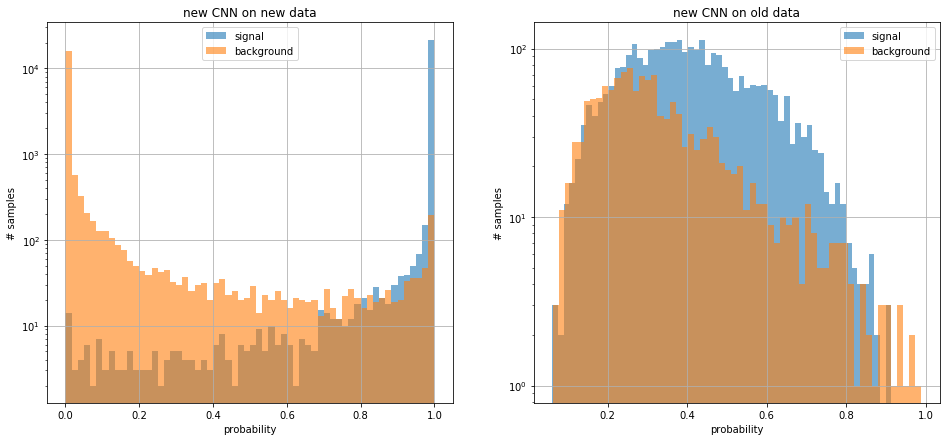

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
for i, k in enumerate(['new_new', 'new_old']):
    preds[k] = model[k].predict(X_test[k[-3:]], batch_size=128, verbose=1)
    print(k+' roc_auc:\t',round(roc_auc_score(y_test[k[-3:]], preds[k]), 5))
    pos[k], neg[k] = pos_neg(y_test[k[-3:]],preds[k])
    axes[i].hist(pos[k][:,0], bins=60, label='signal', alpha=0.6)
    axes[i].hist(neg[k][:,0], bins=60, label='background', alpha=0.6)
    axes[i].grid()
    axes[i].set_title(k[:3]+' CNN on '+k[-3:]+' data')
    axes[i].set_yscale('log')
    axes[i].set_ylabel('# samples')
    axes[i].set_xlabel('probability')
    axes[i].legend()
    #plt.show()

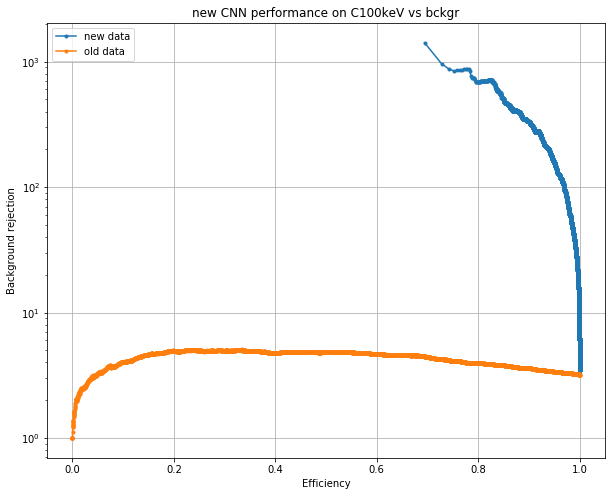

In [7]:
plt.figure(figsize=(10,8))
plt.grid()
plt.title('new CNN performance on C100keV vs bckgr')
for k in ['new_new', 'new_old']:
    prec_curve[k], rec_curve[k], thr_curve[k] = precision_recall_curve(y_test[k[-3:]], preds[k])
    plt.plot(rec_curve[k][:-1],(1-prec_curve[k][:-1])**-1,'.-', label=k[-3:]+' data')
    #print('Output probability threshold for '+k+' plotted between:\n\t',thr_curve[k][-len(thr_curve[k])//2],'\t',thr_curve[k][-2])
plt.xlabel('Efficiency')
plt.ylabel('Background rejection')
plt.yscale('log')
plt.legend(loc=2)
plt.show()

### Residual model, trained on the new data, performes quite badly on the old data.

## Old CNN

4561/4561 [==============================] - 7s     
old_old roc_auc:	 0.99399
41754/41754 [==============================] - 66s    
old_new roc_auc:	 0.45129


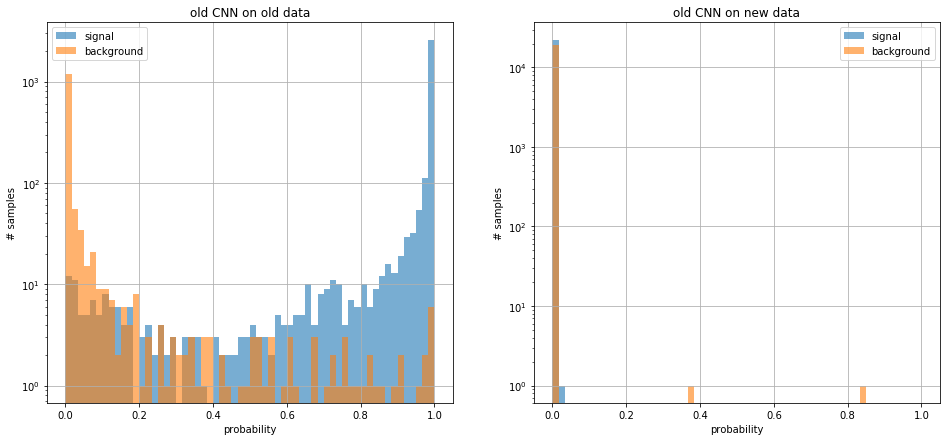

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
for i, k in enumerate(['old_old', 'old_new']):
    preds[k] = model[k].predict(X_test[k[-3:]], batch_size=128, verbose=1)
    print(k+' roc_auc:\t',round(roc_auc_score(y_test[k[-3:]], preds[k]), 5))
    pos[k], neg[k] = pos_neg(y_test[k[-3:]],preds[k])
    axes[i].hist(pos[k][:,0], bins=60, label='signal', alpha=0.6, range=(0,1))
    axes[i].hist(neg[k][:,0], bins=60, label='background', alpha=0.6, range=(0,1))
    axes[i].grid()
    axes[i].set_title(k[:3]+' CNN on '+k[-3:]+' data')
    axes[i].set_yscale('log')
    axes[i].set_ylabel('# samples')
    axes[i].set_xlabel('probability')
    axes[i].legend()
    #plt.show()

/home/scanner-ml/anaconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in reciprocal
  


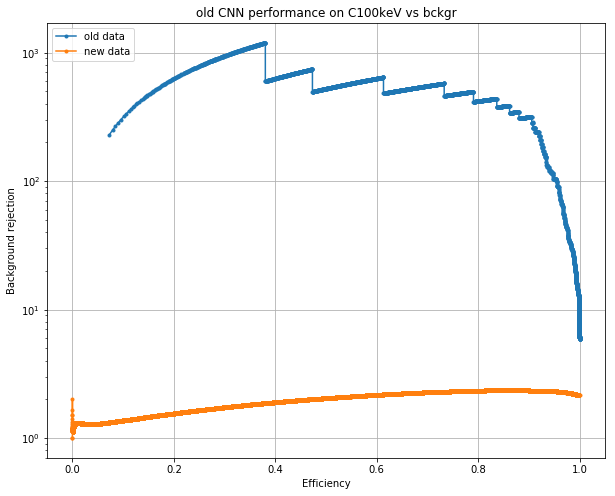

In [9]:
plt.figure(figsize=(10,8))
plt.grid()
plt.title('old CNN performance on C100keV vs bckgr')
for k in ['old_old', 'old_new']:
    prec_curve[k], rec_curve[k], thr_curve[k] = precision_recall_curve(y_test[k[-3:]], preds[k])
    plt.plot(rec_curve[k][:-1],(1-prec_curve[k][:-1])**-1,'.-', label=k[-3:]+' data')
    #print('Output probability threshold for '+k+' plotted between:\n\t',thr_curve[k][-len(thr_curve[k])//2],'\t',thr_curve[k][-2])
plt.xlabel('Efficiency')
plt.ylabel('Background rejection')
plt.yscale('log')
plt.legend(loc=2)
plt.show()

### The old (non-residual) model, trained on the old data, performes dramatically badly on the new data.
#### In fact, it is very certain that both new signal and background are background!

### C60keV and C30keV test for Old CNN

X_test shape:	(36822, 32, 32, 8, 1)
y_test shape:	(36822,)
36822/36822 [==============================] - 59s    
C30keV roc_auc:	 0.39097
X_test shape:	(37999, 32, 32, 8, 1)
y_test shape:	(37999,)
37999/37999 [==============================] - 61s    
C60keV roc_auc:	 0.41896


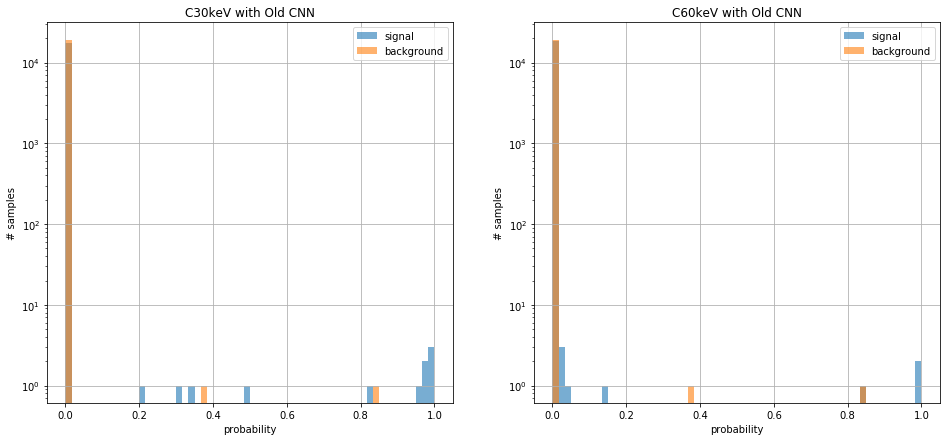

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
for i,k in enumerate(['C30keV','C60keV']):
    X_test[k], y_test[k], _ = load_data(sig_n=k, training=False, shuf_ind={})
    preds[k] = model['old_new'].predict(X_test[k], batch_size=128, verbose=1)
    print(k+' roc_auc:\t',round(roc_auc_score(y_test[k], preds[k]), 5))
    pos[k], neg[k] = pos_neg(y_test[k],preds[k])
    axes[i].hist(pos[k][:,0], bins=60, label='signal', alpha=0.6, range=(0,1))
    axes[i].hist(neg[k][:,0], bins=60, label='background', alpha=0.6, range=(0,1))
    axes[i].grid()
    axes[i].set_title(k+' with Old CNN')
    axes[i].set_yscale('log')
    axes[i].set_ylabel('# samples')
    axes[i].set_xlabel('probability')
    axes[i].legend()

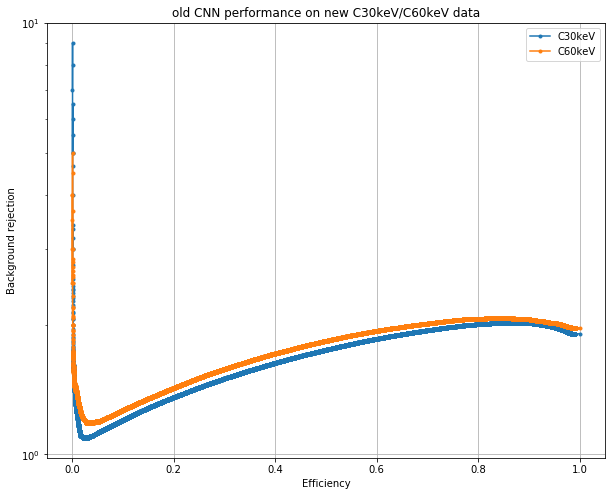

In [11]:
plt.figure(figsize=(10,8))
plt.grid()
plt.title('old CNN performance on new C30keV/C60keV data')
for k in ['C30keV', 'C60keV']:
    prec_curve[k], rec_curve[k], thr_curve[k] = precision_recall_curve(y_test[k], preds[k])
    plt.plot(rec_curve[k][:-1],(1-prec_curve[k][:-1])**-1,'.-', label=k)
    #print('Output probability threshold for '+k+' plotted between:\n\t',thr_curve[k][-len(thr_curve[k])//2],'\t',thr_curve[k][-2])
plt.xlabel('Efficiency')
plt.ylabel('Background rejection')
plt.yscale('log')
plt.legend(loc=1)
plt.show()

#### The performance of the old model for different signal classes is the same.

#### Possible reasons for such behaviour:
* Different background classes led to some huge differences in the features models learned.
    * However, new C100keV samples are not recognised as signal by the old network and vice versa.
* Changes in the scanning techniques together with the physical changes in different samples (C100keV tracks are from different emulsions) led to drastic variations in the track images